This version implements a basic Random Forest model for predicting Weighted Moving Average (WMA) changes in financial data. Key features include:

Data Preparation:

Calculates WMA and creates lagged WMA features
Uses OHLCV (Open, High, Low, Close, Volume) data


Splits data into training and testing sets
Uses RandomForestRegressor with fixed hyperparameters


Evaluation:

Calculates Mean Squared Error, R-squared, and Directional Accuracy
Provides feature importance ranking
Makes predictions on the test set
Calculates F1 score for direction prediction

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import talib

def prepare_features(data):
    # Calculate WMA
    data['WMA'] = talib.WMA(data.Close, timeperiod=3)
    
    # Create lagged WMA features
    for i in range(1, 6):
        data[f'WMA_t-{i}'] = data['WMA'].shift(i)
    
    return data

def get_X(data):
    """Return model design matrix X"""
    X_columns = ['Open', 'High', 'Low', 'Close', 'Volume'] + [col for col in data.columns if col.startswith('WMA')]
    return data[X_columns]

def get_y(data):
    """Return dependent variable y as WMA(3)t+1 - WMA(3)t"""
    return data['WMA'].shift(-1) - data['WMA']

data = EURUSD.copy()
data = prepare_features(data)

# Get X and y
X = get_X(data)
y = get_y(data)
X = X[:-1]
y = y[:-1]

# Remove NaN values
X = X.dropna()
y = y.loc[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Directional accuracy
directional_accuracy = np.mean((y_test > 0) == (y_pred > 0))
print(f"\nDirectional Accuracy: {directional_accuracy}")

# Note: F1 score is typically used for classification tasks, not regression.
# If you want to use F1 score, you'd need to convert this to a classification problem.
# For example, you could classify whether the WMA will increase or decrease:

from sklearn.metrics import f1_score

y_class_true = (y_test > 0).astype(int)
y_class_pred = (y_pred > 0).astype(int)

f1 = f1_score(y_class_true, y_class_pred)
print(f"\nF1 Score (for direction prediction): {f1}")

Mean Squared Error: 3.714350515670735e-07
R-squared Score: 0.03709850671849102

Feature Importance:
    feature  importance
4    Volume    0.202902
10  WMA_t-5    0.140737
3     Close    0.137914
7   WMA_t-2    0.085301
8   WMA_t-3    0.072890
6   WMA_t-1    0.071741
9   WMA_t-4    0.067680
0      Open    0.061148
1      High    0.060263
2       Low    0.055804
5       WMA    0.043619

Directional Accuracy: 0.6256256256256256

F1 Score (for direction prediction): 0.6511194029850746


Enhanced Feature Engineering:

Adds technical indicators (RSI, MACD, ATR)
Includes price and volume changes, rolling statistics


Uses StandardScaler for feature normalization

Implements RandomizedSearchCV for hyperparameter tuning
Uses a Pipeline to combine preprocessing and model fitting

Adds Root Mean Squared Error and Mean Absolute Error
Implements proper time series cross-validation

Visualization:
Plots actual vs predicted values
Visualizes residuals distribution
Shows feature importance graphically
Displays actual vs predicted values over time
Plots cumulative returns
Presents a confusion matrix for directional accuracy
Provides a learning curve

In [176]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import talib
from scipy.stats import randint, uniform
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import talib
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns


def prepare_features(data):
    # Calculate WMA
    data['WMA'] = talib.WMA(data.Close, timeperiod=3)
    
    # Create lagged WMA features
    for i in range(1, 6):
        data[f'WMA_t-{i}'] = data['WMA'].shift(i)
    
    # Add more technical indicators
    data['RSI'] = talib.RSI(data.Close)
    data['MACD'], _, _ = talib.MACD(data.Close)
    data['ATR'] = talib.ATR(data.High, data.Low, data.Close)
    
    # Add price changes
    data['Price_Change'] = data.Close.pct_change()
    data['Volume_Change'] = data.Volume.pct_change()
    
    # Add rolling statistics
    data['Rolling_Mean'] = data.Close.rolling(window=20).mean()
    data['Rolling_Std'] = data.Close.rolling(window=20).std()
    
    return data

def get_X(data):
    """Return model design matrix X"""
    X_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'ATR', \
                 'Price_Change', 'Volume_Change', 'Rolling_Mean', 'Rolling_Std'] + \
                [col for col in data.columns if col.startswith('WMA')]
    return data[X_columns]

def get_y(data):
    """Return dependent variable y as WMA(3)t+1 - WMA(3)t"""
    return data['WMA'].shift(-1) - data['WMA']

data = EURUSD.copy()
data = prepare_features(data)

# Get X and y
X = get_X(data)
y = get_y(data)

# Remove the last row (which will have NaN in y due to the shift)
X = X[:-1]
y = y[:-1]

# Remove NaN values
X = X.dropna()
y = y.loc[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'rf__n_estimators': randint(100, 500),
    'rf__max_depth': randint(5, 50),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 10),
    'rf__max_features': uniform(0.1, 0.9)
}

# Perform RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=5)
search = RandomizedSearchCV(pipeline, param_distributions=param_dist, 
                            n_iter=100, cv=tscv, scoring='neg_mean_squared_error', 
                            random_state=42, n_jobs=-1)

search.fit(X_train, y_train)

# Get the best model
best_model = search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.named_steps['rf'].feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Directional accuracy
directional_accuracy = np.mean((y_test > 0) == (y_pred > 0))
print(f"\nDirectional Accuracy: {directional_accuracy}")

# F1 score for direction prediction
from sklearn.metrics import f1_score
y_class_true = (y_test > 0).astype(int)
y_class_pred = (y_pred > 0).astype(int)
f1 = f1_score(y_class_true, y_class_pred)
print(f"\nF1 Score (for direction prediction): {f1}")

# Cross-validation score
cv_scores = cross_val_score(best_model, X, y, cv=tscv, scoring='neg_mean_squared_error')
print(f"\nCross-validation RMSE: {np.sqrt(-cv_scores).mean()} (+/- {np.sqrt(-cv_scores).std() * 2})")

# Print best parameters
print("\nBest parameters:")
print(search.best_params_)




plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance.plot(x='feature', y='importance', kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot actual vs predicted over time
plt.figure(figsize=(16, 8))
plt.plot(y_test.index, y_test.values, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('WMA Change')
plt.title('Actual vs Predicted WMA Change Over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Plot cumulative returns
cumulative_actual = (1 + y_test).cumprod()
cumulative_pred = (1 + pd.Series(y_pred, index=y_test.index)).cumprod()

plt.figure(figsize=(16, 8))
plt.plot(cumulative_actual.index, cumulative_actual, label='Actual', alpha=0.7)
plt.plot(cumulative_pred.index, cumulative_pred, label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix for directional accuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_class_true, y_class_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Directional Prediction')
plt.tight_layout()
plt.show()

# Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=tscv, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Mean Squared Error: 4.168612691174195e-07
Root Mean Squared Error: 0.0006456479451817527
Mean Absolute Error: 0.0004480510402555751
R-squared Score: 0.24973768656637352

Feature Importance:
          feature  importance
8    Price_Change    0.706999
5             RSI    0.100040
4          Volume    0.066302
6            MACD    0.023636
9   Volume_Change    0.017529
11    Rolling_Std    0.011843
10   Rolling_Mean    0.011136
17        WMA_t-5    0.010810
7             ATR    0.010370
14        WMA_t-2    0.007923
16        WMA_t-4    0.007863
15        WMA_t-3    0.006807
0            Open    0.005181
2             Low    0.003276
13        WMA_t-1    0.003192
3           Close    0.002904
12            WMA    0.002288
1            High    0.001902

Directional Accuracy: 0.6398390342052314

F1 Score (for direction prediction): 0.6239495798319328

Cross-validation RMSE: 0.0005800908959671544 (+/- 0.00012299445911334632)

Best parameters:
{'rf__max_depth': 5, 'rf__max_features': 0.70812

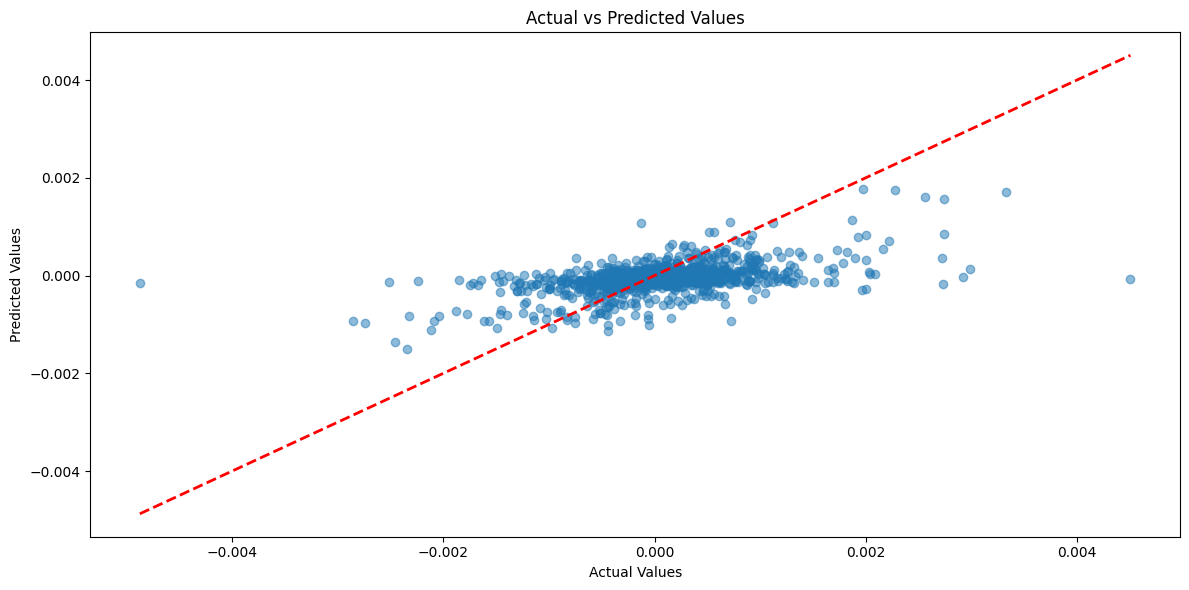

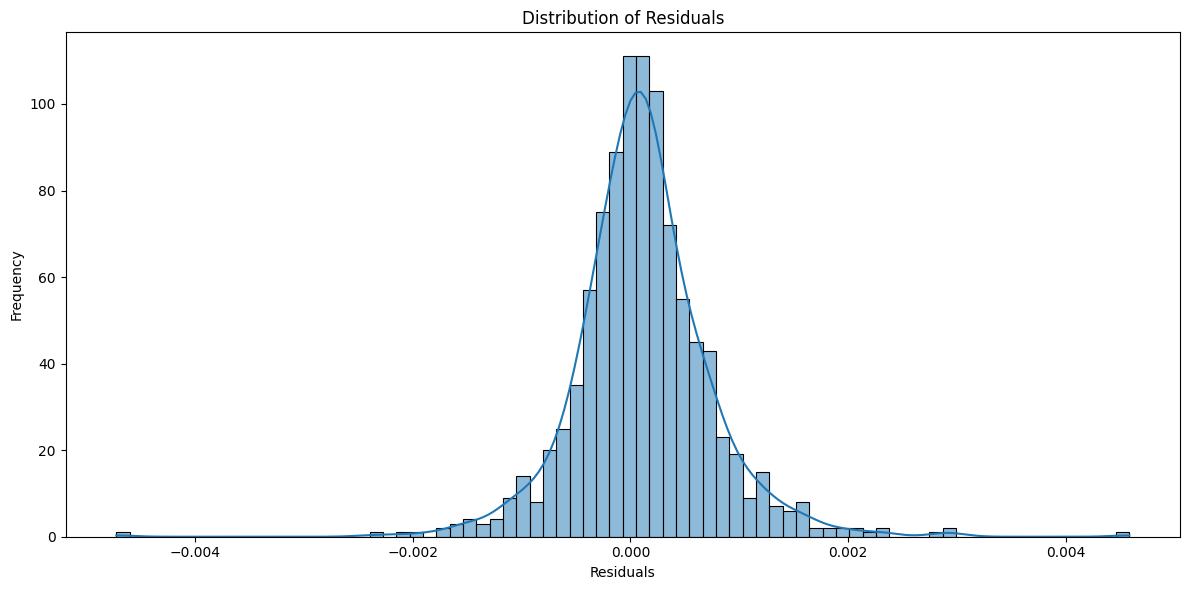

<Figure size 1200x800 with 0 Axes>

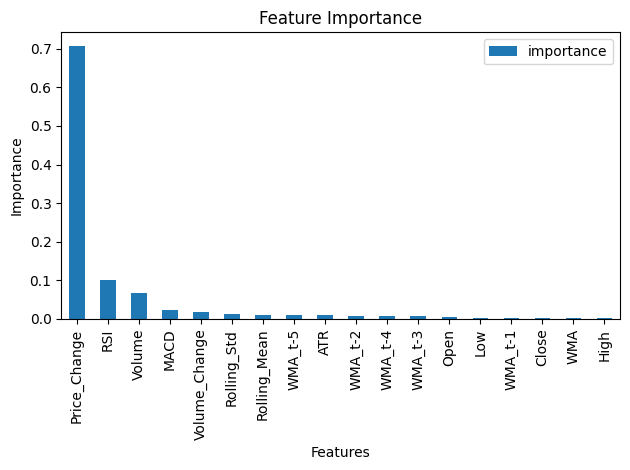

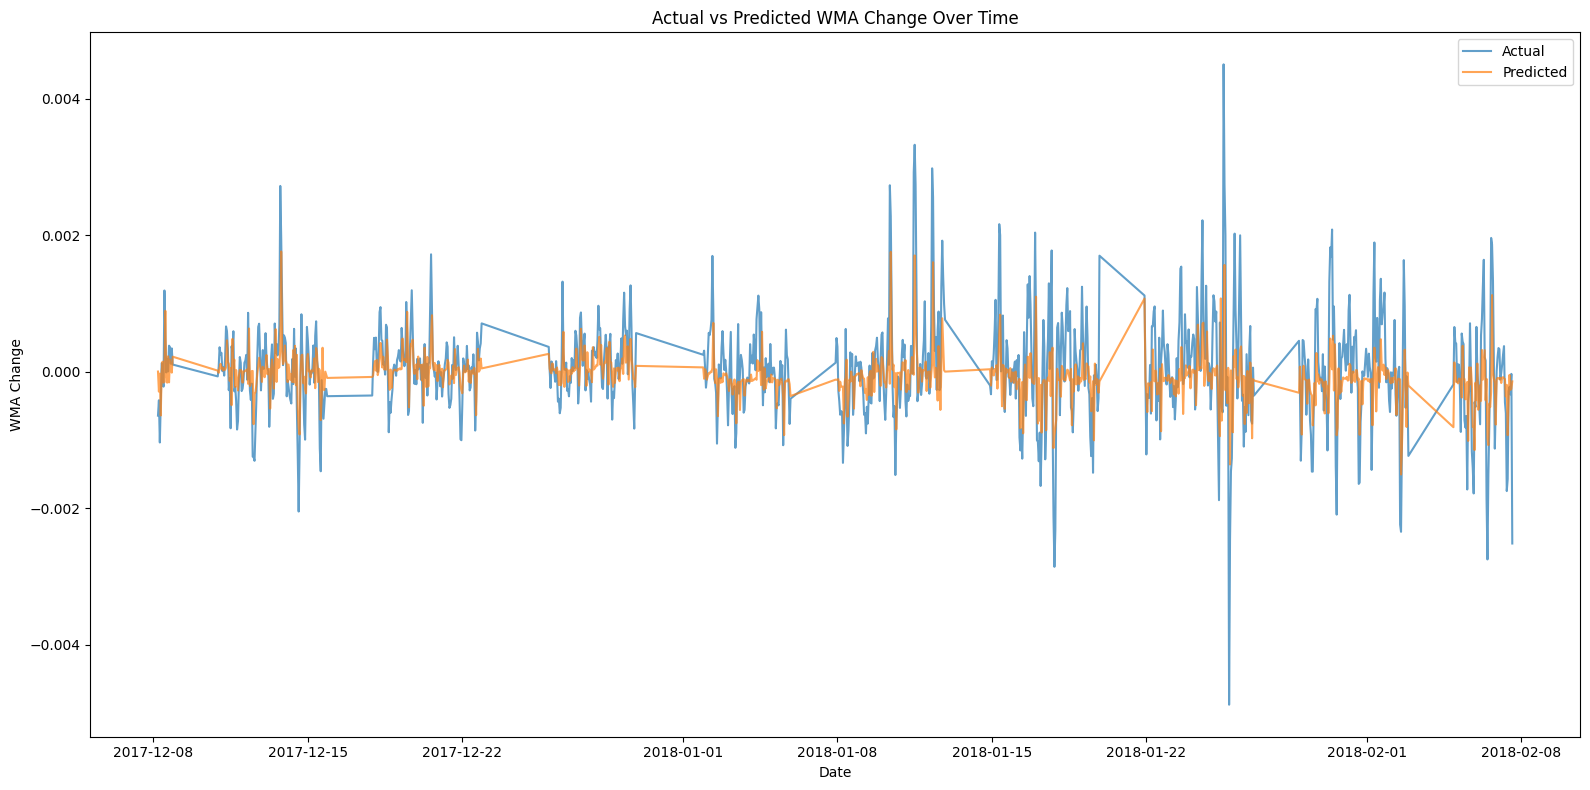

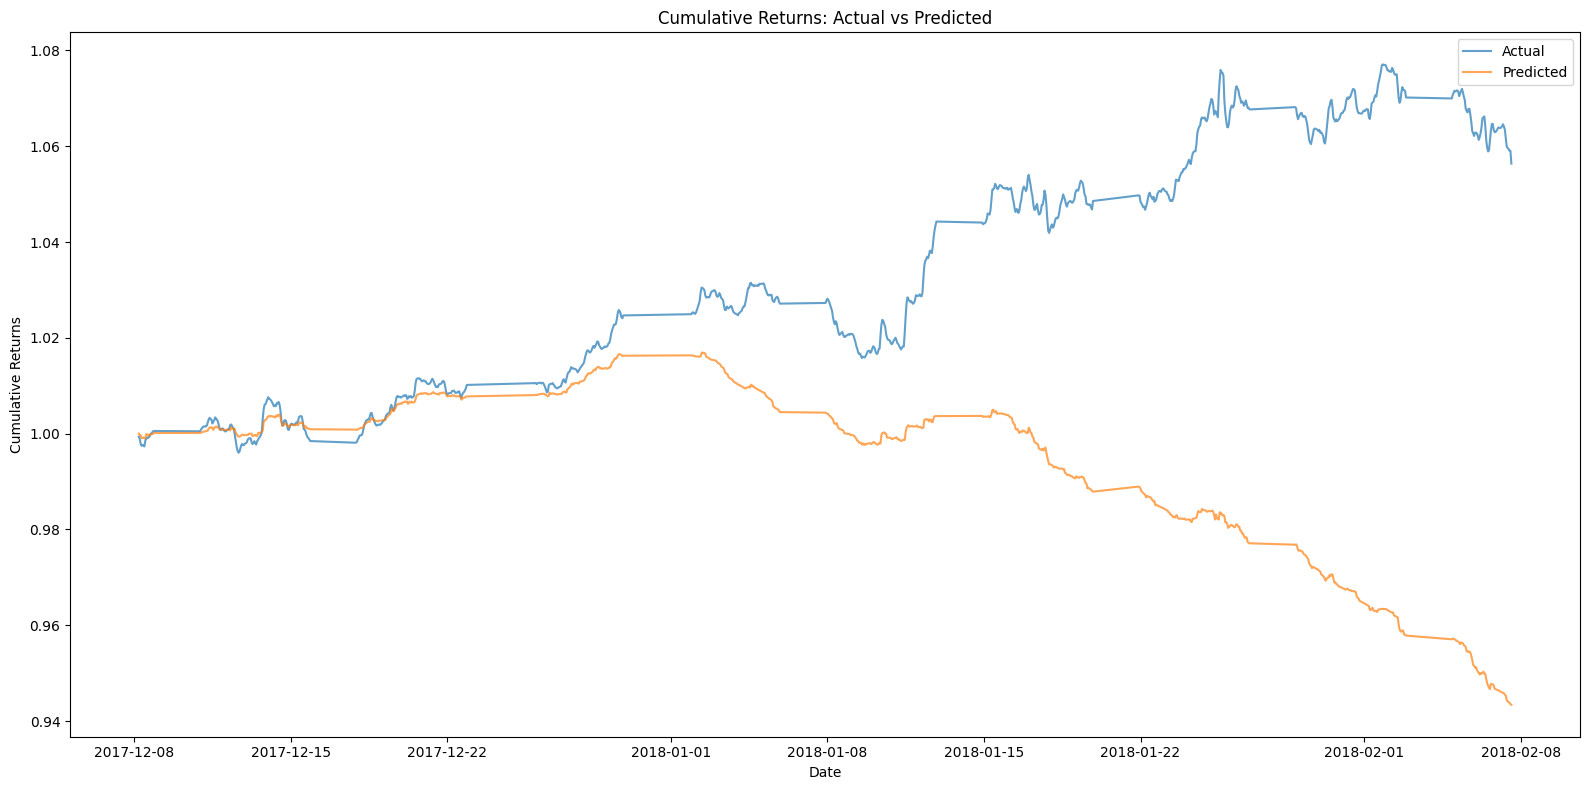

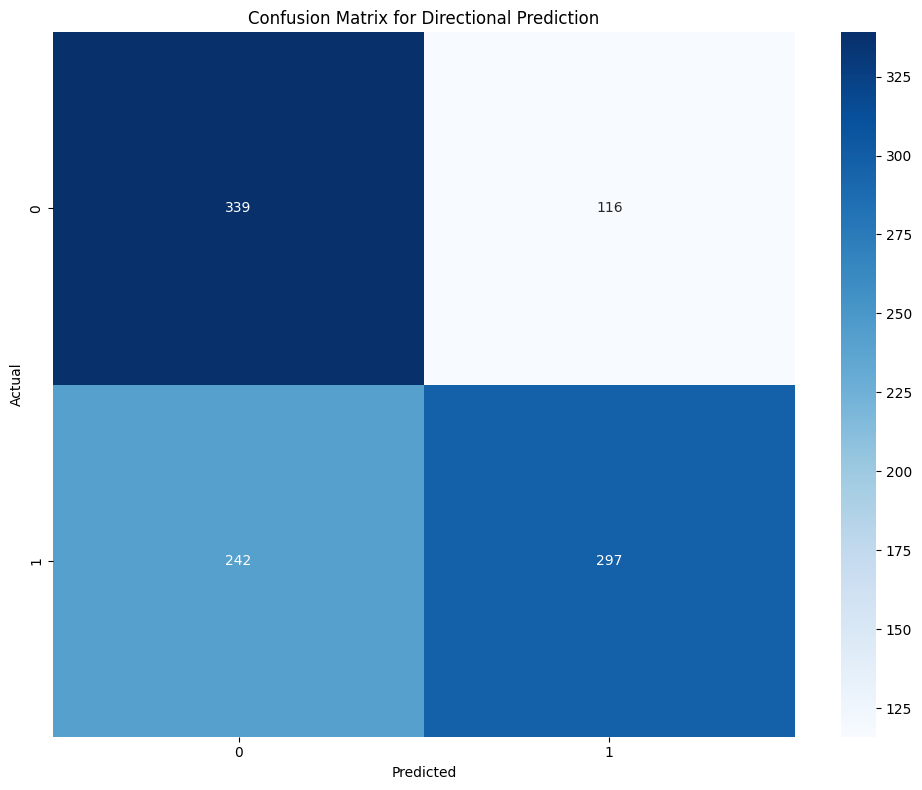

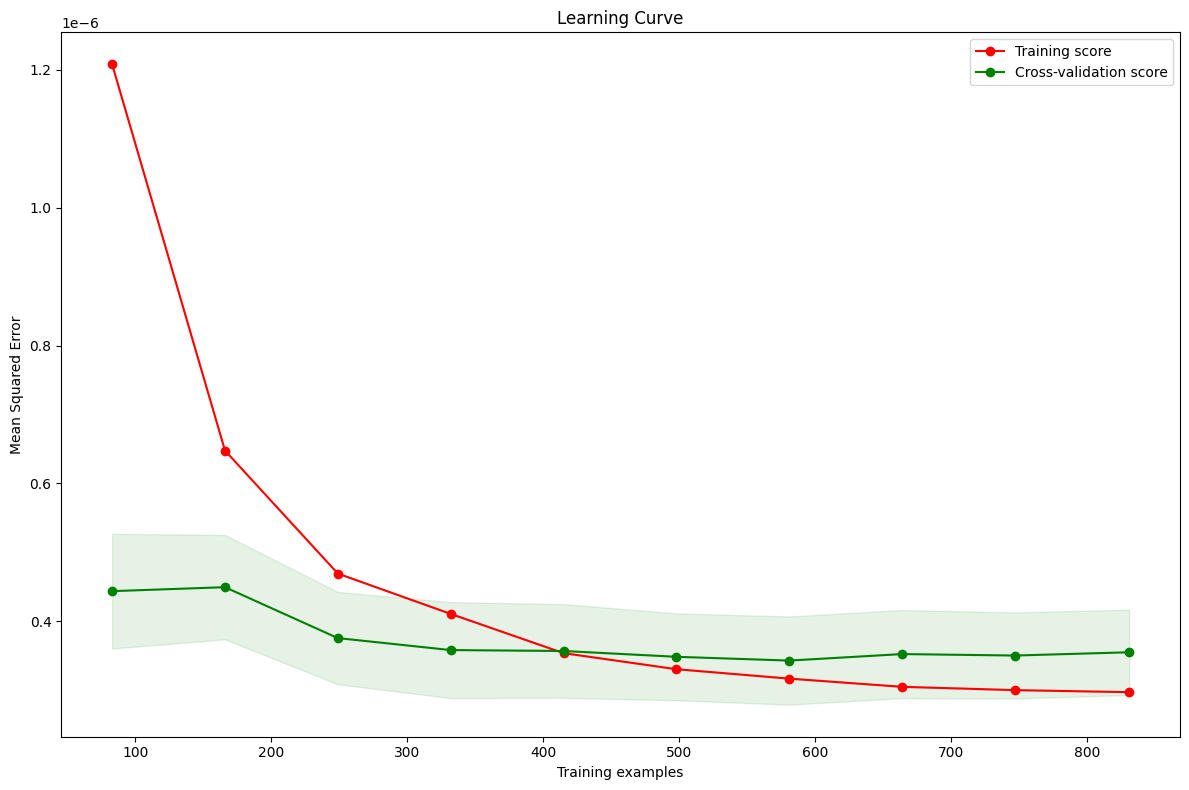

This final iteration implements a rolling window approach to address potential performance degradation over time:

Rolling Window Implementation:

Initially trains on 3 months of data
Tests on the subsequent 1 months
Retrains every 3 months using the most recent data


Allows the model to adapt to changing market conditions
Provides a more realistic simulation of live trading scenarios


Collects and combines results from all testing periods
Calculates overall performance metrics


Plots actual vs predicted values over the entire period
Shows cumulative returns for the entire testing period


Visualizes rolling MSE, MAE, and R-squared
Helps identify periods of good or poor performance


Conclusion: 
Cumulative Returns, ie difference in Wma, doen't improve because once there is error in previous part, that gets added. I think most of the stock data has noise so these results are good

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import talib
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

data = EURUSD.copy()
# Prepare features
data = prepare_features(data)

# Get X and y
X = get_X(data)
y = get_y(data)

# Remove the last row (which will have NaN in y due to the shift)
X = X[:-1]
y = y[:-1]

# Remove NaN values
X = X.dropna()
y = y.loc[X.index]

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'rf__n_estimators': randint(10, 500),
    'rf__max_depth': randint(5, 50),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 10),
    'rf__max_features': uniform(0.1, 0.9)
}

# Function to train model and make predictions
def train_and_predict(X_train, y_train, X_test):
    search = RandomizedSearchCV(pipeline, param_distributions=param_dist, 
                                n_iter=100, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    return best_model.predict(X_test), best_model

# Initialize lists to store results
all_y_test = []
all_y_pred = []
all_dates = []
models = []

# Set the initial training period and test period
train_period = timedelta(days=90)  # 3 months for initial training
test_period = timedelta(days=30)  # 1 months for testing

start_date = X.index[0]
end_date = X.index[-1]

while start_date + train_period + test_period <= end_date:
    train_end = start_date + train_period
    test_end = train_end + test_period
    
    # Split the data
    X_train = X.loc[start_date:train_end]
    y_train = y.loc[start_date:train_end]
    X_test = X.loc[train_end:test_end]
    y_test = y.loc[train_end:test_end]
    
    # Train model and make predictions
    y_pred, model = train_and_predict(X_train, y_train, X_test)
    
    # Store results
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_dates.extend(X_test.index)
    models.append(model)
    
    # Move the window forward
    start_date = train_end
    train_period = test_period  # After initial training, use the test period as the training period

# Convert results to pandas Series
y_test_series = pd.Series(all_y_test, index=all_dates)
y_pred_series = pd.Series(all_y_pred, index=all_dates)

# Evaluate the model
mse = mean_squared_error(y_test_series, y_pred_series)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_series, y_pred_series)
r2 = r2_score(y_test_series, y_pred_series)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

# Directional accuracy
directional_accuracy = np.mean((y_test_series > 0) == (y_pred_series > 0))
print(f"\nDirectional Accuracy: {directional_accuracy}")

# F1 score for direction prediction
from sklearn.metrics import f1_score
y_class_true = (y_test_series > 0).astype(int)
y_class_pred = (y_pred_series > 0).astype(int)
f1 = f1_score(y_class_true, y_class_pred)
print(f"\nF1 Score (for direction prediction): {f1}")

# Plot actual vs predicted over time
plt.figure(figsize=(16, 8))
plt.plot(y_test_series.index, y_test_series.values, label='Actual', alpha=0.7)
plt.plot(y_pred_series.index, y_pred_series.values, label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('WMA Change')
plt.title('Actual vs Predicted WMA Change Over Time (Rolling Window)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot cumulative returns
cumulative_actual = (1 + y_test_series).cumprod()
cumulative_pred = (1 + y_pred_series).cumprod()

plt.figure(figsize=(16, 8))
plt.plot(cumulative_actual.index, cumulative_actual, label='Actual', alpha=0.7)
plt.plot(cumulative_pred.index, cumulative_pred, label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns: Actual vs Predicted (Rolling Window)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot rolling performance metrics
window = 30  # 30-day rolling window
rolling_mse = ((y_test_series - y_pred_series) ** 2).rolling(window).mean()
rolling_mae = (y_test_series - y_pred_series).abs().rolling(window).mean()
rolling_r2 = y_test_series.rolling(window).corr(y_pred_series) ** 2

plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(rolling_mse.index, rolling_mse.values)
plt.title('Rolling MSE')
plt.subplot(3, 1, 2)
plt.plot(rolling_mae.index, rolling_mae.values)
plt.title('Rolling MAE')
plt.subplot(3, 1, 3)
plt.plot(rolling_r2.index, rolling_r2.values)
plt.title('Rolling R-squared')
plt.tight_layout()
plt.show()

### Strategy without mlflow

In [1]:
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
import talib
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from backtesting import Backtest, Strategy
from bokeh.plotting import figure, show
import numpy as np
from backtesting import Backtest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from backtesting.test import EURUSD, SMA

N_TRAIN = 400


def prepare_features(data):
    # Calculate WMA
    data['WMA'] = talib.WMA(data.Close, timeperiod=3)
    
    # Create lagged WMA features
    for i in range(1, 6):
        data[f'WMA_t-{i}'] = data['WMA'].shift(i)
    return data

def get_X(data):
    """Return model design matrix X"""
    X_columns = data.filter(like='WMA').columns
    
    # Combine OHLC columns with 'X' columns
    all_columns = ['Open', 'High', 'Low', 'Close'] + list(X_columns)
    return data[all_columns].values

def get_y(data):
    """Return dependent variable y as WMAt+1"""
    # Shift WMA by -1 to get the next day's WMA (WMAt+1) difference
    return data['WMA'].shift(-1) - data['WMA']


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    
    # Ensure X and y have the same number of samples
    min_samples = min(len(X), len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    
    # Remove NaN values
    isnan = np.isnan(y) | np.isnan(X).any(axis=1)
    X = X[~isnan]
    y = y[~isnan]
    
    return X, y


data = EURUSD.copy()
data = prepare_features(data)

class EnhancedBollingerBandStrategy(Strategy):
    n=20
    k=3

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = RandomForestRegressor(max_depth=7, n_estimators=10, random_state=0)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        X = X[:-1]
        y = y[:-1]
        X = X[:N_TRAIN]
        y = y[:N_TRAIN]
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator of the length of data
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')
        
        self.upper, self.middle, self.lower = self.I(talib.BBANDS, self.data.Close, timeperiod=self.n, nbdevup=self.k, nbdevdn=self.k)
        
        self.atr = self.I(talib.ATR, self.data.High, self.data.Low, self.data.Close, timeperiod=self.n)

    def next(self):
        if len(self.data) < N_TRAIN:
            return

        X = get_X(self.data.df.iloc[-1:])
        predicted_wma_change = self.clf.predict(X)[0]
        predicted_wma = self.data.WMA[-1] + predicted_wma_change

        upper = self.upper[-1]
        lower = self.lower[-1]
        atr = self.atr[-1]
        close = self.data.Close[-1]

        if not self.position:
            if predicted_wma <= lower:
                self.buy()
            elif predicted_wma >= upper:
                self.sell()
        elif self.position.is_long:
            if predicted_wma < close - 3 * atr:
                self.position.close()
            elif predicted_wma > upper:
                self.position.close()
        elif self.position.is_short:
            if predicted_wma > close + 3 * atr:
                self.position.close()
            elif predicted_wma < lower:
                self.position.close()

bt = Backtest(data, EnhancedBollingerBandStrategy, commission=.0002, margin=.05)
bt.run()

/Users/bread/opt/anaconda3/envs/ml4t/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Start                     2017-04-19 09:00:00
End                       2018-02-07 15:00:00
Duration                    294 days 06:00:00
Exposure Time [%]                       86.06
Equity Final [$]                 19896.936298
Equity Peak [$]                  22158.804548
Return [%]                          98.969363
Buy & Hold Return [%]               14.628937
Return (Ann.) [%]                   99.515478
Volatility (Ann.) [%]              218.005753
Sharpe Ratio                         0.456481
Sortino Ratio                        1.616852
Calmar Ratio                         1.770311
Max. Drawdown [%]                  -56.213567
Avg. Drawdown [%]                   -6.386898
Max. Drawdown Duration      118 days 09:00:00
Avg. Drawdown Duration        6 days 21:00:00
# Trades                                    5
Win Rate [%]                             60.0
Best Trade [%]                       8.298948
Worst Trade [%]                     -2.420015
Avg. Trade [%]                    

## Final strategy below

  0%|          | 0/503 [00:00<?, ?it/s]

2024/08/18 18:55:35 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_MMM_2004-01-01_to_2023-12-31' does not exist. Creating a new experiment.
[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:55:38 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_AOS_2004-01-01_to_2023-12-31' does not exist. Creating a new experiment.
[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:55:41 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_ABT_2004-01-01_to_2023-12-31' does not exist. Creating a new experiment.
[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:55:45 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_ABBV_2004-01-01_to_2023-12-31' does not exist. Creating a new experiment.
[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:55:46 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_ACN_2004-01-01_to_2023-12-31' d

$BF.B: possibly delisted; No price data found  (1d 2004-01-01 -> 2023-12-31)


[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:59:01 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_BG_2004-01-01_to_2023-12-31' does not exist. Creating a new experiment.
[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:59:04 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_BXP_2004-01-01_to_2023-12-31' does not exist. Creating a new experiment.
[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:59:07 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_CDNS_2004-01-01_to_2023-12-31' does not exist. Creating a new experiment.
[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:59:10 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_5_CZR_2004-01-01_to_2023-12-31' does not exist. Creating a new experiment.
[*********************100%%**********************]  1 of 1 completed
2024/08/18 18:59:11 INFO mlflow.tracking.fl

                               Start                  End  \
count                            495                  495   
mean   2005-08-15 06:26:54.545454592  2023-12-29 00:00:00   
min              2004-01-02 00:00:00  2023-12-29 00:00:00   
25%              2004-01-02 00:00:00  2023-12-29 00:00:00   
50%              2004-01-02 00:00:00  2023-12-29 00:00:00   
75%              2004-01-02 00:00:00  2023-12-29 00:00:00   
max              2022-01-19 00:00:00  2023-12-29 00:00:00   
std                              NaN                  NaN   

                           Duration  Exposure Time [%]  Equity Final [$]  \
count                           495         495.000000        495.000000   
mean   6709 days 17:33:05.454545408          19.943563      17949.890626   
min               709 days 00:00:00           0.000000          0.000000   
25%              7301 days 00:00:00           0.000000      10000.000000   
50%              7301 days 00:00:00           0.000000      10000.0000

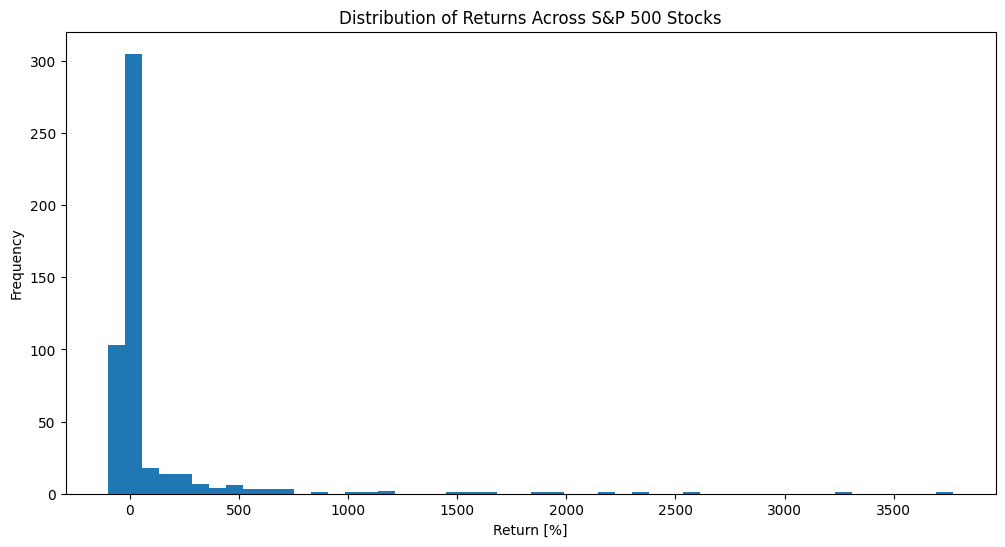


MLflow Tracking URI: sqlite:///mlflow2.db
Use 'mlflow ui' command to view detailed results in the MLflow UI


In [51]:
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
import talibA
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import warnings
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import os
from datetime import datetime
import re

warnings.filterwarnings('ignore')

# Global variables
N_TRAIN = 400
START_DATE = "2004-01-01"
END_DATE = "2023-12-31"
EXPERIMENT_NAME = "MLflow_5"

# Main execution
# Set MLflow tracking URI (adjust as needed)
mlflow.set_tracking_uri("sqlite:///mlflow2.db")
mlflow.set_experiment(f"{EXPERIMENT_NAME}_{START_DATE}_to_{END_DATE}")

def prepare_features(data):
    # Calculate WMA
    data['WMA'] = talib.WMA(data.Close, timeperiod=3)
    
    # Create lagged WMA features
    for i in range(1, 6):
        data[f'WMA_t-{i}'] = data['WMA'].shift(i)
    return data

def get_X(data):
    """Return model design matrix X"""
    X_columns = data.filter(like='WMA').columns
    
    # Combine OHLC columns with 'X' columns
    all_columns = ['Open', 'High', 'Low', 'Close'] + list(X_columns)
    return data[all_columns].values

def get_y(data):
    """Return dependent variable y as WMAt+1"""
    # Shift WMA by -1 to get the next day's WMA (WMAt+1) difference
    return data['WMA'].shift(-1) - data['WMA']


def run_backtest(ticker):
    try:
        # Download data
        data = yf.download(ticker, start=START_DATE, end=END_DATE)
        if len(data) < N_TRAIN:
            return None

        # Prepare features
        data = prepare_features(data)

        # Run backtest
        bt = Backtest(data, EnhancedBollingerBandStrategy, cash=10000, commission=.002)
        result = bt.run()

        result['Ticker'] = ticker
        return result

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return None


def log_results_to_mlflow(result):
    if result is None:
        return

    ticker = result['Ticker']

    # Log parameters
    mlflow.log_param("start_date", START_DATE)
    mlflow.log_param("end_date", END_DATE)
    mlflow.log_param("bollinger_period", EnhancedBollingerBandStrategy.n)
    mlflow.log_param("bollinger_std", EnhancedBollingerBandStrategy.k)
    
    # Log all scalar metrics from the result
    for key, value in result.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            mlflow.log_metric(re.sub(r'[^a-zA-Z0-9]', '', key.lower()), value)

    # Log equity curve
    plt.figure(figsize=(10, 6))
    result['_equity_curve']['Equity'].plot()
    plt.title(f'Equity Curve - {ticker}')
    plt.tight_layout()
    equity_curve_path = f"{ticker}_equity_curve.png"
    plt.savefig(equity_curve_path)
    plt.close()
    mlflow.log_artifact(equity_curve_path)
    os.remove(equity_curve_path)  # Clean up the file after logging

# Get S&P 500 tickers
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]
    return table['Symbol'].tolist()


if __name__ == "__main__":
    tickers = get_sp500_tickers()
    # Run backtests sequentially
    results = []
    for ticker in tqdm(tickers):  # Sequential execution
        # mlflow.set_experiment(f"{EXPERIMENT_NAME}_{ticker}_{START_DATE}_to_{END_DATE}")
        with mlflow.start_run(run_name=f"{EXPERIMENT_NAME}_{ticker}_{START_DATE}_to_{END_DATE}", nested=True):
            result = run_backtest(ticker)
            if result is not None:
                results.append(result)
                log_results_to_mlflow(result)
            

    if results:
        # Convert results to DataFrame and save
        results_df = pd.DataFrame(results)
        results_df.to_csv('sp500_enhanced_bollinger_results.csv', index=False)
        
        # Print summary statistics
        print(results_df.describe())
        
        # Identify top performing stocks
        top_performers = results_df.nlargest(10, 'Return [%]')
        print("\nTop 10 Performing Stocks:")
        print(top_performers)
        
        # Identify worst performing stocks
        worst_performers = results_df.nsmallest(10, 'Return [%]')
        print("\nBottom 10 Performing Stocks:")
        print(worst_performers)
        
        # Plot overall distribution of returns
        plt.figure(figsize=(12, 6))
        plt.hist(results_df['Return [%]'], bins=50)
        plt.title('Distribution of Returns Across S&P 500 Stocks')
        plt.xlabel('Return [%]')
        plt.ylabel('Frequency')
        returns_dist_path = 'sp500_returns_distribution.png'
        plt.savefig(returns_dist_path)
        plt.show()
        
        # Log overall results as a separate experiment
        # mlflow.set_experiment(f"{EXPERIMENT_NAME}_S&P500_Overall_Results")
        with mlflow.start_run(run_name=f"{EXPERIMENT_NAME}_S&P500_Overall_Results", nested=True):
            mlflow.log_param("total_stocks", len(results_df))
            mlflow.log_param("start_date", START_DATE)
            mlflow.log_param("end_date", END_DATE)
            mlflow.log_metric("mean_return", results_df['Return [%]'].mean())
            mlflow.log_metric("median_return", results_df['Return [%]'].median())
            mlflow.log_metric("mean_sharpe", results_df['Sharpe Ratio'].mean())
            
            # Log distribution plot
            mlflow.log_artifact(returns_dist_path)
            os.remove(returns_dist_path)  # Clean up the file after logging
        
            # Log results CSV
            mlflow.log_artifact('sp500_enhanced_bollinger_results.csv')
        
        # Print MLflow tracking URI
        print(f"\nMLflow Tracking URI: {mlflow.get_tracking_uri()}")
        print("Use 'mlflow ui' command to view detailed results in the MLflow UI")
